In [99]:
"""

f(R) gravity emulator: for fast generation of P_mg/P_lcdm


Requires the following installations:

1. R (R studio is the easiest option: https://www.rstudio.com/products/rstudio/download/).
Installing R packages is easy, in R studio, command install.packages("package_name") works
(https://www.dummies.com/programming/r/how-to-install-load-and-unload-packages-in-r/)
The following R packages are required:
    1a. RcppCNPy
    1b. DiceKriging
    1c. GPareto

2. rpy2 -- which runs R under the hood (pip install rpy2 should work)
# http://rpy.sourceforge.net/rpy2/doc-2.1/html/index.html
# conda install -c r rpy2

Built by N. Ramachandra and M. Binois 
"""

##### Generic packages ###############
import numpy as np
import matplotlib.pylab as plt
import time
import glob
import os


###### R kernel imports from rpy2 #####
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri

rpy2.robjects.numpy2ri.activate()
from rpy2.robjects import r
from rpy2.robjects.packages import importr


####### PLOTTING SETTINGS #####
from itertools import cycle
import matplotlib.ticker as ticker
from matplotlib import gridspec


plt.rc('text', usetex=True)  # Slower
plt.rc('axes',labelsize= 10)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


########## R imports ############
# RcppCNPy = importr('RcppCNPy')
# RcppCNPy.chooseCRANmirror(ind=1) # select the first mirror in the list
## There are other importr calls in PCA and GP functions


In [100]:
############################# PARAMETERS ##############################
nRankMax = 8 ## Number of basis vectors in truncated PCA
del_idx =  [5, 25, 4, 42]  ## holdouts for testing
snap_ID = 99
############################# INPUT FILES ##############################

plotsDir = "./Plots/" ## Data folder
dataDir = "./Data/Emulator_data/" ## Data folder

paramIn = dataDir + 'mg.design'  ## parameter file



az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratios_' + str(snap_ID) + '.txt'
nRankMax = 8 ## Number of basis vectors in truncated PCA
GPmodel = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID) +'.RData"'  ## Double and single quotes are necessary
## DELETE the GPmodels or provide a new name if you want a new calculation
# num_holdout = 4
################################# I/O #################################


loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
parameter_array_all = np.loadtxt(paramIn)
z_ID = az[snap_ID, 1]

########################## Deleting hold-out from training ##############


PmPl = np.delete(PmPl_all, del_idx, axis = 0)
parameter_array = np.delete(parameter_array_all, del_idx, axis = 0)


####################### porting to R backend #######################

nr, nc = PmPl[:,:].shape
y_train = ro.r.matrix(PmPl[:,:], nrow=nr, ncol=nc)
ro.r.assign("y_train2", y_train)
r('dim(y_train2)')

nr, nc = parameter_array[:,:].shape
u_train = ro.r.matrix(parameter_array[:,:], nrow=nr, ncol=nc)
ro.r.assign("u_train2", u_train)
r('dim(u_train2)')

46,5


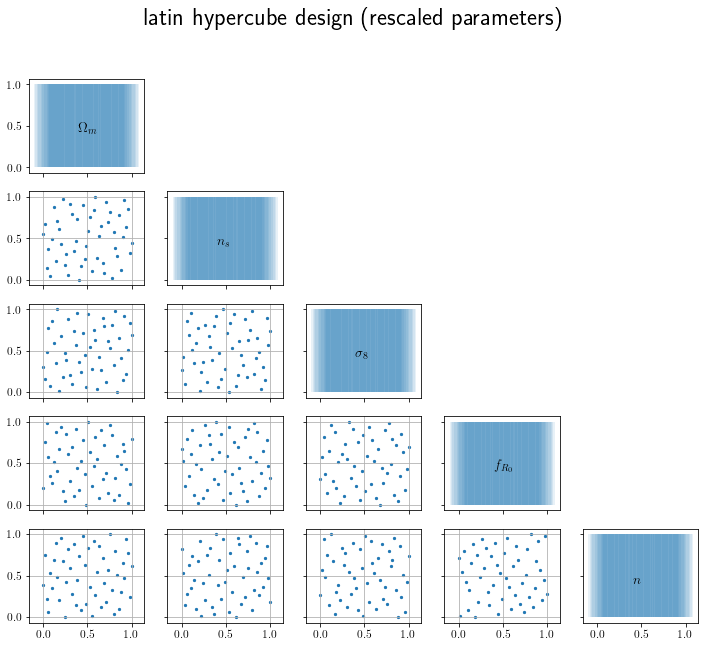

In [123]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']

def rescale01(f):
    return (f - np.min(f)) / (np.max(f) - np.min(f))

lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(12, 10) )
    plt.suptitle('latin hypercube design (rescaled parameters)', fontsize = 24)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
                
#             if (j > i):
                
                
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)

    for i in range(lhd.shape[1]):
        for j in range(i + 1, lhd.shape[1]):

            plt.delaxes(a[i][j])
    plt.show()


plot_params(lhd)

In [29]:
########################### PCA ###################################
def PCA_decomp():
#     Dicekriging = importr('DiceKriging')
    r('require(foreach)')
    ro.r.assign("nrankmax", nRankMax)
    r('svd(y_train2)')
    r('svd_decomp2 <- svd(y_train2)')
    r('svd_weights2 <- svd_decomp2$u[, 1:nrankmax] %*% diag(svd_decomp2$d[1:nrankmax])')


In [30]:
######################## GP PREDICTION ###############################

def GP_model_load(GPmodel):
    GPareto = importr('GPareto')

    ro.r('''

    GPmodel <- gsub("to", "",''' + GPmodel + ''')

    ''')

    r('''if(file.exists(GPmodel)){
            load(GPmodel)
        }else{
            print("ERROR: No trained GP file")
         }''')
    print('Loaded: ', GPmodel)
    
    
def GP_predict(para_array):
    GPareto = importr('GPareto')


    para_array = np.expand_dims(para_array, axis=0)
    nr, nc = para_array.shape
    Br = ro.r.matrix(para_array, nrow=nr, ncol=nc)

    ro.r.assign("Br", Br)
    r('print("loaded model in R kernel: ")')
    r('print(GPmodel)')

    r('wtestsvd2 <- predict_kms(models_svd2, newdata = Br , type = "UK")')
    r('reconst_s2 <- t(wtestsvd2$mean) %*% t(svd_decomp2$v[,1:nrankmax])')

    y_recon = np.array(r('reconst_s2'))

    return y_recon[0]

In [31]:
#################### PCA DECOMPOSITION DONE AGAIN ##############

PCA_decomp()

#################### LOADING TRAINED GP MODEL ##############

GP_model_load(GPmodel)

R[write to console]: Loading required package: foreach



Loaded:  "R_GP_model_rank8snap99.RData"


[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
Time per emulation 0.100  s
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
Time per emulation 0.111  s
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
Time per emulation 0.119  s


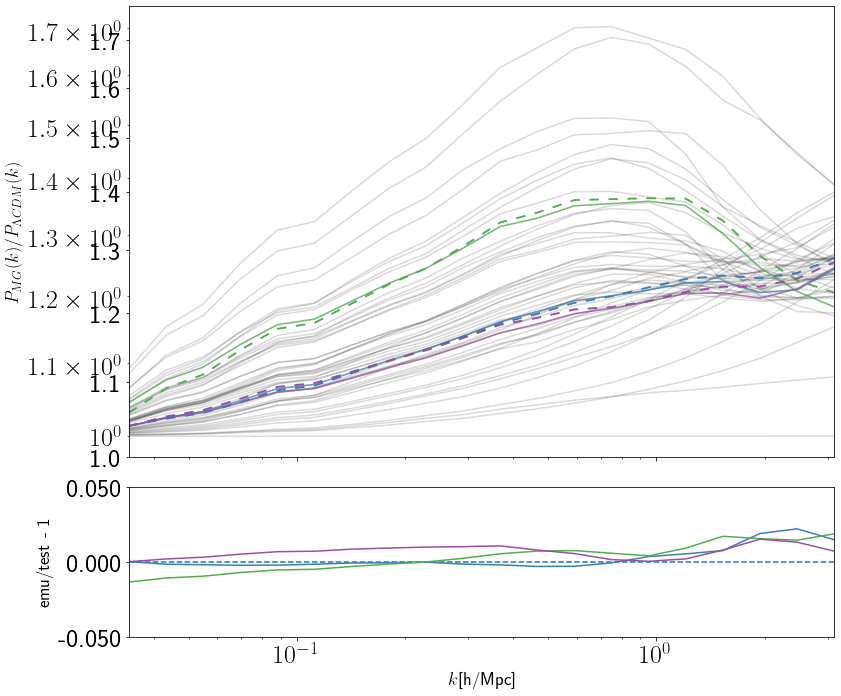

In [32]:
##################################### TESTING ##################################
plt.rc('font', size=18)  # 

PlotPrior = True

if PlotPrior:

    plt.figure(999, figsize=(14, 12))

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$',  fontsize = 18)

    ax1.set_xlabel(r'$k$[h/Mpc]',  fontsize = 18)
    ax1.axhline(y=0, ls='dashed')


    ax0.set_yscale('log')
    ax0.set_xscale('log')
    ax1.set_xscale('log')

    ax1.set_ylabel(r'emu/test - 1',  fontsize = 18)
    ax1.set_ylim(-5e-2, 5e-2)

    ax0.plot(kvals, PmPl_all.T, alpha=0.15, color='k')

    start, end = ax0.get_ylim()
    ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
    ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))


    ax0.set_xlim(kvals[0], kvals[-1])
    ax1.set_xlim(kvals[0], kvals[-1])
    ax0.set_xticklabels([])


    color_id = 0
    for x_id in del_idx[1:]:
        color_id = color_id + 1

        time0 = time.time()
        x_decodedGPy = GP_predict(parameter_array_all[x_id])  ## input parameters
        time1 = time.time()
        print('Time per emulation %0.3f' % (time1 - time0), ' s')
        x_test = PmPl_all[x_id]

        ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=plt.cm.Set1(color_id))
        ax0.plot(kvals, x_test, alpha=0.7, label='test', color=plt.cm.Set1(color_id))

        ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=plt.cm.Set1(color_id))


plt.savefig(plotsDir + "Emu.png",  bbox_inches="tight", dpi=200)

plt.show()

[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model

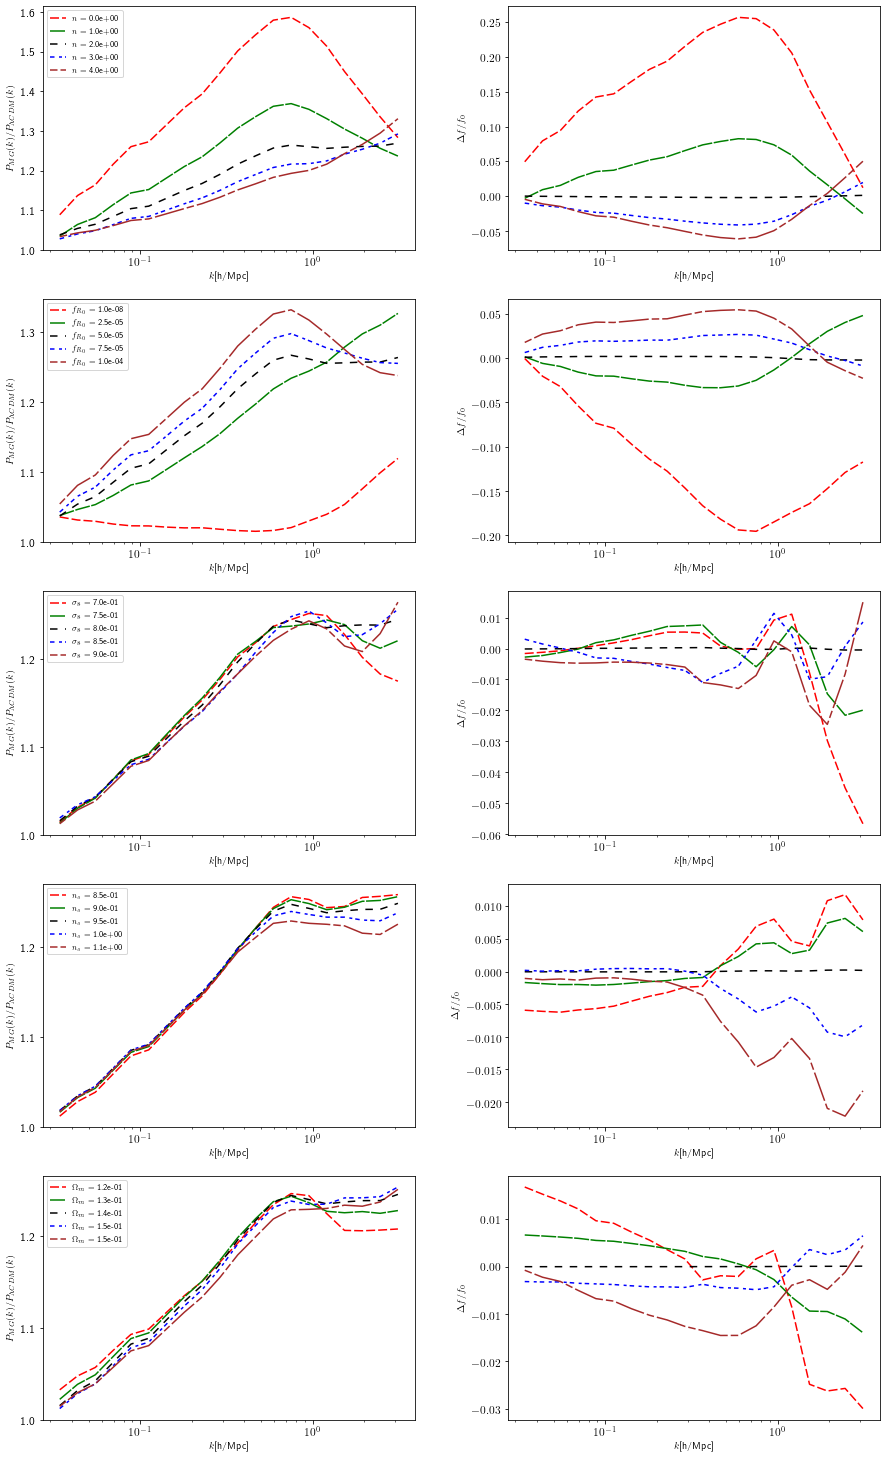

In [19]:
PlotCls = True

if PlotCls:
    
    numPlots = 5

    fig, ax = plt.subplots(5,2, figsize = (15,26))
    plt.subplots_adjust(wspace=0.25)
    
    allMax = np.max(parameter_array, axis = 0)
    allMin = np.min(parameter_array, axis = 0)
    allMean = np.mean(parameter_array, axis = 0)
    Pk_mean = GP_predict(allMean) 
    
    for paramNo in range(5):
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  
            x_decodedGPy = GP_predict(para_plot) 
            lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])

            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()

            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')

            ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


        start, end = ax[4-paramNo, 0].get_ylim()
        ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
        ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity.png",  bbox_inches="tight", dpi=200)

plt.show()

In [33]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4, p5 = theta

    new_params = np.array([p1, p2, p3, p4, p5])

    model = GP_predict(new_params)
    # return -0.5 * (np.sum(((y - model) / yerr) ** 2.))
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))

In [34]:
######### CALLING THE EMULATOR ##############
#### input arguments: (Om, ns, s8, fR0, n)
#### output: P_mg/P_lcdm in 20 bins
#### Example: 

GP_predict([0.1, 1.0, 0.8, 3e-5, 1.5])

[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap99.RData"


array([1.0179959 , 1.03382655, 1.04395177, 1.0641859 , 1.0839633 ,
       1.0908846 , 1.11161683, 1.13219493, 1.15015369, 1.1732119 ,
       1.19608   , 1.22007064, 1.24161497, 1.25537634, 1.25558752,
       1.23596331, 1.21338913, 1.20611401, 1.20331644, 1.20445327])

0.618647 0.568874
Loaded:  "R_GP_model_rank8snap60.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap60.RData"
Loaded:  "R_GP_model_rank8snap62.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap62.RData"
Loaded:  "R_GP_model_rank8snap62.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap62.RData"
Loaded:  "R_GP_model_rank8snap61.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap61.RData"


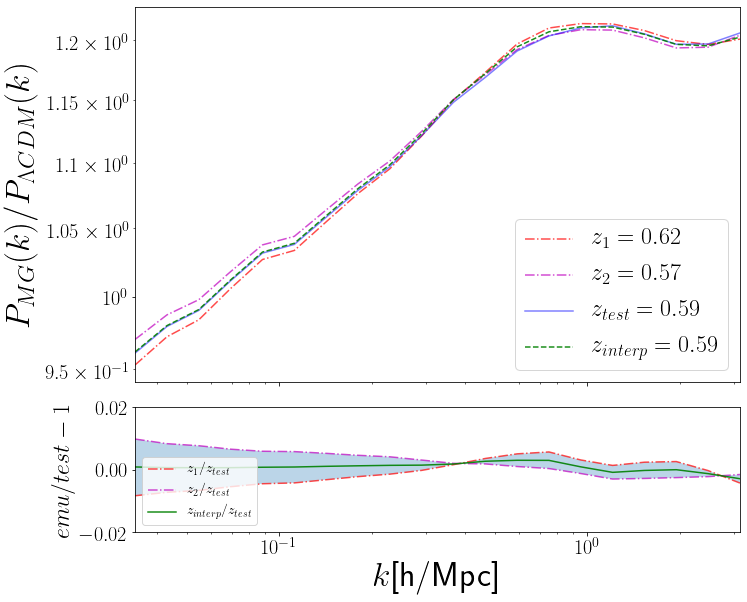

In [131]:
az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
z_all = az[:, 1]

snap_ID_z1 = 60
snap_ID_z2 = 62
snap_ID_z3 = 61

print(z_all[snap_ID_z1], z_all[snap_ID_z2])



Om, ns, s8, fR0, n = 0.1, 1.0, 0.8, 3e-5, 1.5

GPmodel_z1 = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID_z1) +'.RData"'  ## Double and single quotes are necessary
GP_model_load(GPmodel = GPmodel_z1)
Pk_z1 = GP_predict([Om, ns, s8, fR0, n])
z1 = z_all[snap_ID_z1]
    
GPmodel_z2 = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID_z2) +'.RData"'  ## Double and single quotes are necessary
GP_model_load(GPmodel = GPmodel_z2)
Pk_z2 = GP_predict([Om, ns, s8, fR0, n])
z2 = z_all[snap_ID_z2]

GPmodel_z2 = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID_z2) +'.RData"'  ## Double and single quotes are necessary
GP_model_load(GPmodel = GPmodel_z2)
Pk_z2 = GP_predict([Om, ns, s8, fR0, n])
z2 = z_all[snap_ID_z2]

GPmodel_z3 = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID_z3) +'.RData"'  ## Double and single quotes are necessary
GP_model_load(GPmodel = GPmodel_z3)
Pk_z3 = GP_predict([Om, ns, s8, fR0, n])
z3 = z_all[snap_ID_z3]


# plt.plot(Pk_z1)
# plt.plot(Pk_z2)


Pk_interp12 = np.zeros_like(Pk_z1)
# for k_in in range(np.shape(Pk_z1)[0]):
#     xp = [z2, z1]
# #     xp = [1./(1 + z2), 1/(1 + z1)]
# #     xp = [1 + z2, 1 + z1]

# #     fp = [Pk_z2[k_in], Pk_z1[k_in]]
#     fp = [Pk_z2[k_in], Pk_z1[k_in]]

#     Pk_interp12[k_in] = np.interp(z3, xp, fp)

Pk_interp12 = Pk_z2 + (Pk_z1 - Pk_z2)*(z3 - z2)/(z1 - z2)
    
plt.figure(14232, figsize=(12, 10))
plt.rcParams.update({'font.size': 14})


gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$',  fontsize = 34)

ax1.set_xlabel(r'$k$[h/Mpc]',  fontsize = 34)
# ax1.axhline(y=0, ls='dashed', color = 'k', alpha = 0.5)


ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')

ax1.set_ylabel(r'$emu/test - 1$',  fontsize = 24)
ax1.set_ylim(-2e-2, 2e-2)




ax0.set_xlim(kvals[0], kvals[-1])
ax1.set_xlim(kvals[0], kvals[-1])
ax0.set_xticklabels([])

# ax0.set_xlim(kvals[3], kvals[-5])
# ax1.set_xlim(kvals[3], kvals[-5])



ax0.plot(kvals, Pk_z1, 'r-.', alpha = 0.7, label =  r'$z_1 = %0.2f$'%z1)
ax0.plot(kvals, Pk_z2, 'm-.',  alpha = 0.7, label = r'$z_2 = %0.2f$'%z2)
ax0.plot(kvals, Pk_z3, 'b-',  alpha = 0.5, label = r'$z_{test} = %0.2f$'%z3)
ax0.plot(kvals,Pk_interp12, 'g--',  alpha = 0.9,  lw = 1.5, label = r'$z_{interp} = %0.2f$'%z3)

ax1.plot(kvals, Pk_z1/Pk_z3 - 1, 'r-.',  alpha = 0.7, label = r'$z_1/z_{test}$')
ax1.plot(kvals, Pk_z2/Pk_z3 - 1, 'm-.',  alpha = 0.7, label = r'$z_2/z_{test}$')
ax1.plot(kvals, Pk_interp12/Pk_z3 - 1, 'g-',   alpha = 0.9, lw = 1.5, label = r'$z_{interp}/z_{test}$')


ax1.fill_between(kvals, Pk_z1/Pk_z3 - 1, Pk_z2/Pk_z3 - 1, alpha = 0.3)


start, end = ax0.get_ylim()
# ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
# ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
# ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

ax0.legend(loc="lower right", fontsize = 24)
ax1.legend(loc="lower left", fontsize = 14)


In [89]:
az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
z_all = az[:, 1]

def Pk_ratio_linearZ(Om, ns, s8, fR0, n, z):
    
    nRankMax = 8
    
    snap_idx_nearest = (np.abs(z_all - z)).argmin()
    if (z > z_all[snap_idx_nearest]): 
        snap_ID_z1 = snap_idx_nearest - 1
        
    else:
        snap_ID_z1 = snap_idx_nearest 
  

    snap_ID_z2 = snap_ID_z1 + 1

    
    
    GPmodel_z1 = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID_z1) +'.RData"'  ## Double and single quotes are necessary
    GP_model_load(GPmodel = GPmodel_z1)
    Pk_z1 = GP_predict([Om, ns, s8, fR0, n])
    z1 = z_all[snap_ID_z1]
    
    GPmodel_z2 = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID_z2) +'.RData"'  ## Double and single quotes are necessary
    GP_model_load(GPmodel = GPmodel_z2)
    Pk_z2 = GP_predict([Om, ns, s8, fR0, n])
    z2 = z_all[snap_ID_z2]
    
    
    print('Linear interpolating for redshift')
    print('z1= '+ str(z_all[snap_ID_z1]))
    print('z2= '+ str(z_all[snap_ID_z2]))

    Pk_interp = np.zeros_like(Pk_z1)
    
    Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
#     for k_in in range(np.shape(Pk_z1)[0]):
        
#         xp = [z2, z1]
#         fp = [Pk_z2[k_in], Pk_z1[k_in]]
#         Pk_interp[k_in] = np.interp(z, xp, fp)
    
    return Pk_interp, Pk_z1, Pk_z2

#### check the order of redshift


# Pk_ratio(0.1, 1.0, 0.8, 3e-5, 1.5, 0.6)

In [90]:
az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
z_all = az[:, 1]

def Pk_ratio_splineZ(Om, ns, s8, fR0, n, z):
    
    nRankMax = 8
    
    snap_idx_nearest = (np.abs(z_all - z)).argmin()
    if (z > z_all[snap_idx_nearest]): 
        snap_ID_z1 = snap_idx_nearest - 1
        
    else:
        snap_ID_z1 = snap_idx_nearest 
  

    snap_ID_z2 = snap_ID_z1 + 1

    
    
    GPmodel_z1 = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID_z1) +'.RData"'  ## Double and single quotes are necessary
    GP_model_load(GPmodel = GPmodel_z1)
    Pk_z1 = GP_predict([Om, ns, s8, fR0, n])
    z1 = z_all[snap_ID_z1]
    
    GPmodel_z2 = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID_z2) +'.RData"'  ## Double and single quotes are necessary
    GP_model_load(GPmodel = GPmodel_z2)
    Pk_z2 = GP_predict([Om, ns, s8, fR0, n])
    z2 = z_all[snap_ID_z2]
    
    
    print('Linear interpolating for redshift')
    print('z1= '+ str(z_all[snap_ID_z1]))
    print('z2= '+ str(z_all[snap_ID_z2]))

    Pk_interp = np.zeros_like(Pk_z1)
    
    Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    for k_in in range(np.shape(Pk_z1)[0]):
        
        xp = [z2, z1]
        fp = [Pk_z2[k_in], Pk_z1[k_in]]
        Pk_interp[k_in] = np.interp(z, xp, fp)
    
#     return Pk_interp, Pk_z1, Pk_z2

#### check the order of redshift


# Pk_ratio(0.1, 1.0, 0.8, 3e-5, 1.5, 0.6)

snap ID =  30
z =  2.088327
sim ID =  42
Loaded:  "R_GP_model_rank8snap30.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap30.RData"
Loaded:  "R_GP_model_rank8snap31.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap31.RData"
Linear interpolating for redshift
z1= 2.088327
z2= 1.997603
Loaded:  "R_GP_model_rank8snap30.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap30.RData"
snap ID =  55
z =  0.758088
sim ID =  42
Loaded:  "R_GP_model_rank8snap55.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap55.RData"
Loaded:  "R_GP_model_rank8snap56.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap56.RData"
Linear interpolating for redshift
z1= 0.758088
z2= 0.72831
Loaded:  "R_GP_model_rank8snap55.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap55.RData"
snap ID =  80
z =  0.228803
sim ID =  42
Loaded:  "R_GP_model_rank8snap80.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap80.RData"
Lo

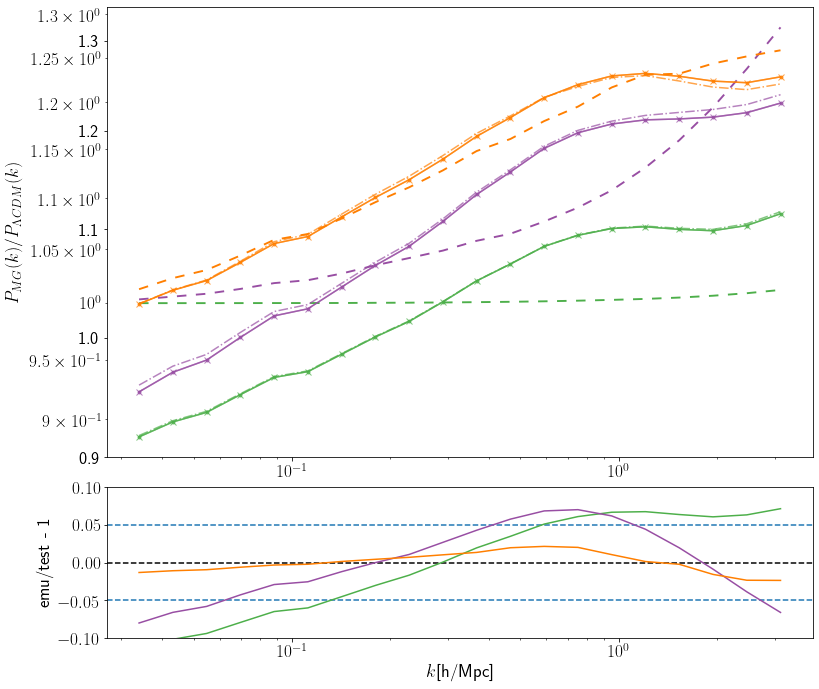

In [93]:
cosmo_id = del_idx[1]
cosmo_id = 49

ax0.set_xlim(kvals[0], kvals[-1])
ax1.set_xlim(kvals[0], kvals[-1])

ax0.set_xticklabels([])

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=12)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$',  fontsize = 18)

ax1.axhline(y=-5e-2, ls='dashed')
ax1.axhline(y=5e-2, ls='dashed')

ax1.set_ylim([-0.1, 0.1])

ax1.set_xlabel(r'$k$[h/Mpc]',  fontsize = 18)
ax1.axhline(y=0, ls='dashed', color = 'k')


ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')

ax1.set_ylabel(r'emu/test - 1',  fontsize = 18)

# snap_id = 22 ### corresponds to z~3 i think -- check it out 
color_id = 1
for snap_zidx in range(30,99,25):
    z_test = z_all[snap_zidx]
    
    print('snap ID = ', snap_zidx)
    print('z = ', z_test)
    print('sim ID = ', x_id)

    fileIn = dataDir + 'ratios_' + str(snap_zidx) + '.txt'
    loadFile = np.loadtxt(fileIn)
    PmPl_test = loadFile[:, 1:].T

    Cosmo = parameter_array_all[cosmo_id]
#     x_test = PmPl_all[cosmo_id]
    x_test = PmPl_test[cosmo_id]

    emu, emu_z1, emu_z2 = Pk_ratio_linearZ(Cosmo[0], Cosmo[1], Cosmo[2], Cosmo[3], Cosmo[4], z_test)
    
    GPmodel_z = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_zidx) +'.RData"'  ## Double and single quotes are necessary
    GP_model_load(GPmodel = GPmodel_z)
    emu_noZ = GP_predict(Cosmo)
#     plt.figure(1465, figsize = (10, 8))
    color_id = color_id + 1

    ax0.plot(kvals, x_test, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='real', color=plt.cm.Set1(color_id))
    
    ax0.plot(kvals, emu, '-', alpha=0.7, label='emu z-interpolated', color=plt.cm.Set1(color_id))
    
    ax0.plot(kvals, emu_z2, '-.', alpha=0.7, label='emu z2', color=plt.cm.Set1(color_id))

    ax0.plot(kvals, emu_z1, '-.', alpha=0.7, label='emu z1', color=plt.cm.Set1(color_id))

    ax0.plot(kvals, emu_noZ, 'x-', alpha=0.7, label='no z', color=plt.cm.Set1(color_id))

    ax1.plot(kvals, emu/x_test - 1, color=plt.cm.Set1(color_id))

    print(15*'=')
    
    
    
start, end = ax0.get_ylim()
ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
# ax0.legend()

plt.show()



In [ ]:
PmPl_test.shape

In [ ]:
z_all[20::10]

In [ ]:
az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
z = az[:, 1]

for snap_ID in range(0, 100, 1):
    nRankMax = 8
    GPmodel_z1 = '"R_GP_model_rank' + str(nRankMax) + 'snap' + str(snap_ID) +'.RData"'  ## Double and single quotes are necessary
    GP_model_load(GPmodel = GPmodel_z1)
    Pk_z1 = GP_predict([0.1, 1.0, 0.8, 3e-5, 1.5])
    
    plt.figure(43215)
    
    plt.plot(Pk_z1[19], z[snap_ID], 'x')
    
plt.show()

In [ ]:
z[snap_ID]

In [42]:
Pk_ratio_linearZ(Cosmo[0], Cosmo[1], Cosmo[2], Cosmo[3], Cosmo[4], 0.2)

Loaded:  "R_GP_model_rank8snap81.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap81.RData"
Loaded:  "R_GP_model_rank8snap82.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap82.RData"
Linear interpolating for redshift
z1= 0.214181
z2= 0.199904


(array([0.99890641, 1.0123665 , 1.02196125, 1.04018543, 1.05964481,
        1.066839  , 1.08698811, 1.10703082, 1.1255857 , 1.14714161,
        1.17008345, 1.18716852, 1.20573449, 1.21549729, 1.22568497,
        1.22775609, 1.21915688, 1.20995663, 1.20716869, 1.21530357]),
 array([0.99936556, 1.01209688, 1.02126272, 1.03874695, 1.05745718,
        1.06450813, 1.08421531, 1.10391723, 1.12223428, 1.14349208,
        1.16677543, 1.18545399, 1.20553295, 1.21762591, 1.22757286,
        1.22962803, 1.22362824, 1.21688874, 1.21405195, 1.22033011]),
 array([0.9989033 , 1.01236833, 1.02196598, 1.04019517, 1.05965962,
        1.06685478, 1.08700688, 1.1070519 , 1.12560838, 1.14716632,
        1.17010585, 1.18718013, 1.20573585, 1.21548288, 1.22567219,
        1.22774341, 1.21912661, 1.20990971, 1.20712209, 1.21526954]))

In [43]:
Pk_ratio_linearZ(Cosmo[0], Cosmo[1], Cosmo[2], Cosmo[3], Cosmo[4], 0.5)

Loaded:  "R_GP_model_rank8snap64.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap64.RData"
Loaded:  "R_GP_model_rank8snap65.RData"
[1] "loaded model in R kernel: "
[1] "R_GP_model_rank8snap65.RData"
Linear interpolating for redshift
z1= 0.52207
z2= 0.4997


(array([0.96783682, 0.98191679, 0.99110445, 1.00860525, 1.02618491,
        1.03227024, 1.0505353 , 1.06894063, 1.08572808, 1.10706706,
        1.12998662, 1.15022955, 1.17153043, 1.18674489, 1.1972231 ,
        1.19989697, 1.19677302, 1.19599523, 1.20470066, 1.22187179]),
 array([0.96471546, 0.97878782, 0.9879778 , 1.00544867, 1.02301368,
        1.02907555, 1.04733976, 1.06575097, 1.08258664, 1.10404064,
        1.12731963, 1.14785529, 1.16946788, 1.18470643, 1.19479725,
        1.19842589, 1.1978969 , 1.1992371 , 1.20829172, 1.22519522]),
 array([0.96787924, 0.98195933, 0.99114695, 1.00864816, 1.02622802,
        1.03231367, 1.05057873, 1.06898399, 1.08577078, 1.1071082 ,
        1.13002287, 1.15026182, 1.17155847, 1.1867726 , 1.19725608,
        1.19991697, 1.19675774, 1.19595116, 1.20465185, 1.22182661]))

In [52]:
snap_zidx = 32
fileIn = dataDir + 'ratios_' + str(snap_zidx) + '.txt'
loadFile = np.loadtxt(fileIn)
PmPl_test = loadFile[:, 1:].T


PmPl_test.shape
# plt.plot(PmPl_test)

(50, 20)

In [53]:
loadFile.shape

(20, 51)